In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset
X = pd.read_csv('../Datasets/NB.csv')
X['Fault'] = 0

y = pd.read_csv('../Datasets/IR - 21.csv')
y['Fault'] = 1

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [4]:
train = X_train.append(y_train)
train

,DE,FE,Fault
103476,0.062585,0.041091,0
96984,-0.075102,-0.013765,0
114732,-0.048190,-0.001233,0
10916,0.069260,0.028558,0
37646,0.040054,0.065335,0
...,...,...,...
45891,0.479590,-0.055473,1
117952,1.090346,-0.036776,1
42613,-0.061319,0.245724,1
43567,-0.548219,0.040475,1


In [5]:
test = X_test.append(y_test)
test

,DE,FE,Fault
121079,0.046313,0.054651,0
107924,-0.015855,0.061636,0
22678,-0.065297,0.122862,0
55190,-0.112652,0.066978,0
92048,0.023991,0.034105,0
...,...,...,...
103358,-0.201013,-0.113411,1
54412,-0.208323,0.096975,1
50632,-0.115735,-0.066156,1
89251,-0.534005,-0.094920,1


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train))
# Random shuffle training data
train.sample(frac=1)

test = pd.DataFrame(scaler.transform(test))

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')

train_PCA = pca.fit_transform(train)
train_PCA = pd.DataFrame(train_PCA)
train_PCA.index = train.index

test_PCA = pca.transform(test)
test_PCA = pd.DataFrame(test_PCA)
test_PCA.index = test.index

In [8]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [9]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [10]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [11]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [12]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [13]:
data_train = np.array(train_PCA.values)
data_test = np.array(test_PCA.values)

In [14]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [15]:
mean_distr = data_train.mean(axis=0)

In [16]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15.0)

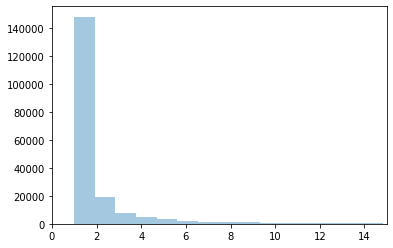

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 50, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

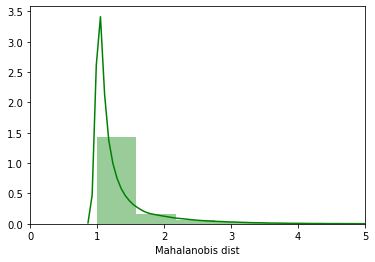

In [18]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [19]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob_dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob_dist'] > anomaly_train['Thresh']
anomaly_train.index = train_PCA.index

In [20]:
anomalies = anomaly_train[anomaly_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Mob_dist    Thresh  Anomaly
96956   4.517914  3.948063     True
96976   4.555471  3.948063     True
96992   4.132244  3.948063     True
97000   5.797345  3.948063     True
97037   4.758685  3.948063     True
...          ...       ...      ...
193552  3.977403  3.948063     True
193628  4.666583  3.948063     True
193645  4.848060  3.948063     True
193682  4.410331  3.948063     True
193826  4.169834  3.948063     True

[1075 rows x 3 columns]
(1075, 3)


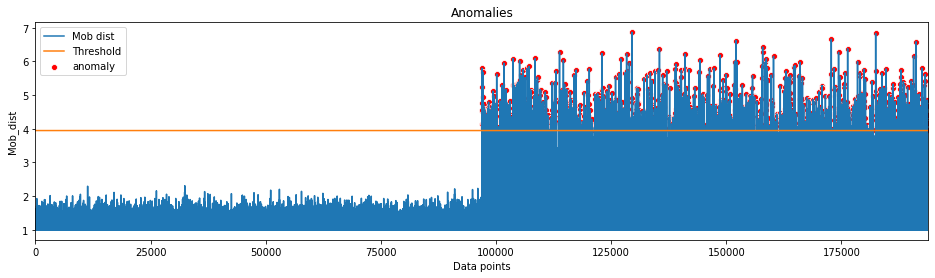

In [21]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(anomaly_train.index, anomaly_train.Mob_dist, label='Mob dist');
ax1.plot(anomaly_train.index, anomaly_train.Thresh, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [22]:
anomaly_test = pd.DataFrame()
anomaly_test['Mob_dist']= dist_test
anomaly_test['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_test['Anomaly'] = anomaly_test['Mob_dist'] > anomaly_test['Thresh']
anomaly_test.index = test_PCA.index
anomaly_test.head()

,Mob_dist,Thresh,Anomaly
0,1.012394,3.948063,False
1,1.025685,3.948063,False
2,1.226046,3.948063,False
3,1.042645,3.948063,False
4,1.000026,3.948063,False


In [23]:
IR_anomalies = anomaly_test[anomaly_test['Anomaly'] == True]
print(IR_anomalies)
print(IR_anomalies.shape)

       Mob_dist    Thresh  Anomaly
24369  4.709383  3.948063     True
24469  4.494370  3.948063     True
24500  5.019177  3.948063     True
24722  4.010349  3.948063     True
24725  4.763041  3.948063     True
...         ...       ...      ...
47686  4.225340  3.948063     True
47782  5.175519  3.948063     True
47864  4.362822  3.948063     True
48170  4.279244  3.948063     True
48310  4.758440  3.948063     True

[259 rows x 3 columns]
(259, 3)


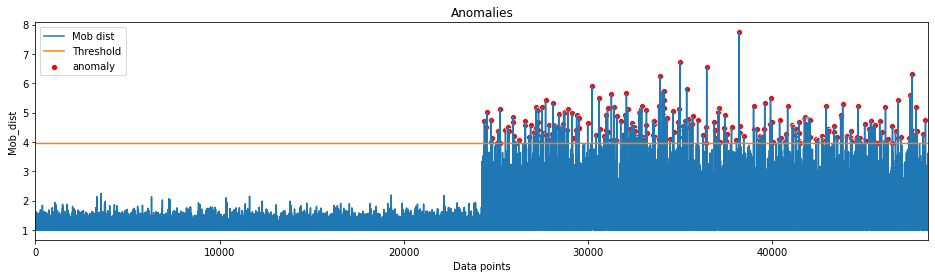

In [24]:
f, (ax2) = plt.subplots(figsize=(16, 4))
ax2.plot(anomaly_test.index, anomaly_test.Mob_dist, label='Mob dist');
ax2.plot(anomaly_test.index, anomaly_test.Thresh, label='Threshold')
g = sns.scatterplot(x=IR_anomalies.index , y=IR_anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_test.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [25]:
print("Anomalies: {}".format(IR_anomalies['Anomaly'].count()))

Anomalies: 259
